# Quick Overview of RLFH

The performance of Language Models until GPT-3 was kind of amazing as-is. What the models of were essentially lacking was the aspect of **alignment**. The language generation aspect was particularly challenging due to heavy hallucinations, toxicity, etc.

The authors of the seminal work **[InstructGPT](https://arxiv.org/pdf/2203.02155)** basically focussed on this aspect of aligning the language models to user's intructions (hence the name!). Their work showcased how we can further fine-tune such models in a supervised way leverage human feedback and reinforcement learning to align them.

## High-Level Overview of the Setup

<img src="./assets/instruct_gpt_rlhf.png">

> Source: https://arxiv.org/pdf/2203.02155

## Key Concepts:

- **Reinforcement Learning (RL)**: A machine learning paradigm where an agent learns to make decisions by performing actions and receiving _rewards or penalties_ .
- **Human Feedback**: Evaluations provided by humans that guide the learning process, ensuring the model's outputs align with human expectations and preferences.

## How Does this Actually Work? Show Me Examples Please?

### Standard Supervised Learning:
- Input: "Generate a story about a dragon and a knight."
- Output: The model generates a story based on its training data.


### Reinforcement Learning From Human Feedback:
- Input: "Generate a story about a dragon and a knight."
- Initial Output: The model generates a story.
- Human Feedback: A human rates the story on coherence, creativity, and engagement.
- Adjusted Output: The model refines its story generation based on the feedback, leading to more engaging and coherent stories over time.

As pointed out in the figure above, one of the ways of bringing this alignment is through:
- Training a **reward model** using a Human labelled dataset.
    - This dataset basically contains rank ordered responses to different inputs to the model
- The reward model learns to predict human preferences based on the provided human feedback by assigning a score (reward) to the outputs of the language model.
-  The output of the reward model is then used to update the policy of the language model (agent) to align with the human feedback (exploration vs exploitation)


<img src="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/trl_overview.png">

> Source: https://huggingface.co/docs/trl/en/quickstart

## PPO vs DPO

There are different ways of performing policy optimisation. The original work follows Proximal Policy Optimisation which requires a separate reward model to tune the Language Model. DPO or Direct Policy Optimisation directly applies updates to the language model thus removing the need for a separate reward model.

> Read more about RL and KL Divergence to understand the topic better


> The KL-divergence between the two outputs is used as an _additional reward signal_ to make sure the generated responses don’t deviate too far from the reference language model.

# Quick Hello World Using PPO

> Can we improve alignment of gpt2?

> Adapted from:
> [[1](https://huggingface.co/docs/trl/en/quickstart)], [[2](https://github.com/antndlcrx/oxford-llms-workshop/blob/main/materials/seminars/day_3/8_LLMs%20alignment%20with%20RLHF.ipynb)]

**NOTE**: Ensure you have high-capacity GPU available for this notebook!

## Install Dependencies

In [1]:
!pip3 install transformers==4.46.3 trl==0.11.3 datasets==3.1.0 accelerate==1.1.1 tensorboard==2.17.1 matplotlib  tensorboardx seaborn

## Import Packages

In [1]:
import random
import torch
import time
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
import numpy as np

tqdm.pandas()

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, pipeline
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import LengthSampler

## Configs

In [2]:
text_input_length = 5
text_output_length = 20
seed = 42

sentiment_pipe_kwargs = {
    "top_k": None,
    "function_to_apply": "none",
    'return_all_scores':False
}

ppo_config = PPOConfig(
    model_name="raghavbali/gpt2-movie_reviewer",
    steps=200,
    learning_rate=1.41e-5,
    remove_unused_columns=False,
    log_with="tensorboard",
    project_kwargs={"logging_dir": "./logs"},
)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
}

ALIGNED_MODEL_NAME = f"aligned-{ppo_config.model_name.split('/')[1]}"

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
# if you want to save your trained model objects , set the flag to True
# and provide a valid HF namespace/username
# Make sure the token you have created has write permissions
SAVE_TRAINED_OBJECTS = False
HF_NAMESPACE_TO_PUSH_TO = "XXXXXX"

if SAVE_TRAINED_OBJECTS and HF_NAMESPACE_TO_PUSH_TO != "XXXXXX":
    print(f"You have chosen to save trained objects to {HF_NAMESPACE_TO_PUSH_TO} ")
else:
    print(f"You have chosed NOT TO save trained objects to HF, objects will remain on your system ")

You have chosed NOT TO save trained objects to HF, objects will remain on your system 


## Download Models

In [4]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(ppo_config.model_name)
# create a reference model
ref_model = create_reference_model(model, num_shared_layers=6)
tokenizer = AutoTokenizer.from_pretrained(ppo_config.model_name)

tokenizer.pad_token = tokenizer.eos_token
generation_kwargs["pad_token_id"] = tokenizer.eos_token_id

In [10]:
!nvidia-smi

Sun Sep 15 17:24:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Prepare Dataset

In [11]:
def prepare_dataset(
    tokenizer, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8
):
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")# ,cache_dir='/workspace'
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) < 500, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [12]:
dataset = prepare_dataset(tokenizer)


def data_collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2410 [00:00<?, ? examples/s]

## Setup PPO Trainer

In [13]:
ppo_trainer = PPOTrainer(ppo_config,
                         model,
                         ref_model,
                         tokenizer,
                         dataset,
                         data_collator=data_collator,
                         )

In [14]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"
else:
    device = ppo_trainer.accelerator.device
print(f"Accelerator Device={device}")

Accelerator Device=0


In [15]:
ppo_trainer.accelerator.device

device(type='cuda')

### Setup Reward Model and Utils

### Reward Assignment

The objective is to align our text generation model towards the alignment signal provided.
To do so, we need to assign a corresponding reward to each output logit

In [16]:
## Get the Reward Model
distilbert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb",eos_token='</s>')
sentiment_pipe = pipeline("sentiment-analysis", "lvwerra/distilbert-imdb", tokenizer=distilbert_tokenizer,device=device)

# test out the pipeline
text = "this movie was really bad!!"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 2.3350484371185303},
 {'label': 'POSITIVE', 'score': -2.726576328277588}]

## Time to Align using RLHF : PPO
- Get a batch of queries and prepare training input
- Get the query responses from the policy (model to be aligned)
- Join query and responses and tokenize for reward based on sentiment analysis
- Optimize policy with PPO using the (query, response, reward) triplet
- Log all the training statistics

In [17]:
from tqdm.notebook import tqdm

In [18]:
output_min_length = 10
output_max_length = 25
num_steps = 5
overall_rewards = list()
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [19]:
generation_kwargs["pad_token_id"]= tokenizer.eos_token_id

In [20]:
def get_rewards(output):
  if output[0]['score']>output[1]['score']:
    if output[0]['label'] == 'POSITIVE':
      return torch.tensor(4*output[0]['score'])
    else:
      return torch.tensor(0.5*output[0]['score'])
  elif output[1]['score']>output[0]['score']:
    if output[1]['label'] == 'POSITIVE':
      return torch.tensor(4*output[1]['score'])
    else:
      return torch.tensor(0.5*output[0]['score'])
  return -1

In [21]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    if epoch >= num_steps:
        break

    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sentiment_pipe_kwargs)
    rewards = list()
    for output in pipe_outputs:
        rewards.append(get_rewards(output))

    overall_rewards.append(rewards)
    #PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print("-".join("" for x in range(100)))

    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


objective/kl: 0.0
ppo/returns/mean: 2.9586243629455566
ppo/policy/advantages_mean: -4.513466222988427e-08
---------------------------------------------------------------------------------------------------
objective/kl: -0.0037075355648994446
ppo/returns/mean: 2.8984031677246094
ppo/policy/advantages_mean: 2.6163904820464268e-08
---------------------------------------------------------------------------------------------------
objective/kl: -0.005904155783355236
ppo/returns/mean: 3.09124493598938
ppo/policy/advantages_mean: -2.6478694792331225e-08
---------------------------------------------------------------------------------------------------
objective/kl: -0.027832351624965668
ppo/returns/mean: 3.1628432273864746
ppo/policy/advantages_mean: -4.605443137961629e-08
---------------------------------------------------------------------------------------------------
objective/kl: 0.13260036706924438
ppo/returns/mean: 3.468047618865967
ppo/policy/advantages_mean: 1.710036734436926e-08
--

### Plot Reward Distribution

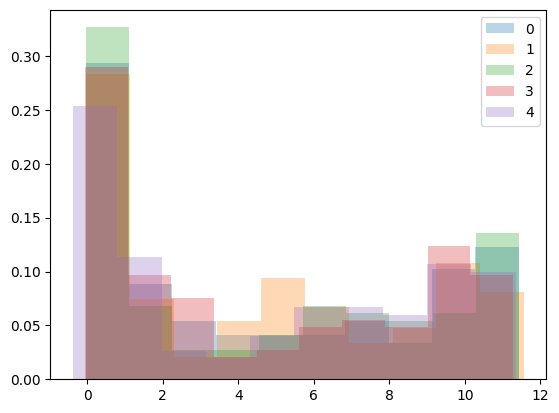

In [22]:
for idx,epoch_rewards in enumerate(overall_rewards):
    plt.hist([i.item() for i in epoch_rewards], density=True, alpha=0.3)
plt.legend(range(10))
plt.show()

### Compare Rewards

In [23]:
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from model
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        input_ids=torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [
    tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data["response (after)"] = [
    tokenizer.decode(response_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
# game_data["rewards (before)"] = [
#     output[1]["score"] for output in sentiment_pipe(texts, **sentiment_pipe_kwargs)
# ]
game_data["rewards (before)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(4*output[0]['score'])
            else:
                game_data["rewards (before)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(4*output[1]['score'])
            else:
                game_data["rewards (before)"].append(0.5*output[0]['score'])

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]

game_data["rewards (after)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[0]['score'])
            else:
                game_data["rewards (after)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[1]['score'])
            else:
                game_data["rewards (after)"].append(0.5*output[0]['score'])


# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,"As usual,",my story. I do not care if the plot is witty ...,", as usual. The only redeeming aspect of this ...",0.841514,1.080847
1,This is a bit of a,considering the money and the clothes coming ...,". The plot is VERY simple, perhaps even worse....",3.745474,2.730340
2,Wonderful film that mixes documentary and,cinematic style with punk rock smiles. This f...,"old-fashioned, is unlike anything else. I hop...",10.201181,11.049273
3,Powers Boothe turns,"stick in the frame! Very smooth, smooth, smoo...","in film, Angelina Goode is a gorgeous woman w...",10.827898,5.603095
4,This is,to look great.John Floyd is an outstanding ex...,"is really creepy. No sometimes sad, but this ...",9.184366,0.002640
5,I thought,was taking the opportunity to:-) if and only ...,it would be somewhat redundant. But this was ...,0.302620,1.105281
6,"""Tulip"" is on","with children under 18, but dwindling over th...","-loud....""EXTREME"" is on call. It's like a mov...",0.104786,0.152721
7,The first,anything resembling Marvel in the United Stat...,"issinfo, I Was almost bummed by the introducti...",1.095995,0.366820
8,Firstly let me say that,and it's incredibly well done - I have been s...,"ing out, AmyKlosenbert does her heart strength...",8.721676,5.614421
9,This is simply the,in America.One of the films borrows a,do what you wish but you can seldom find the,0.471817,4.357355


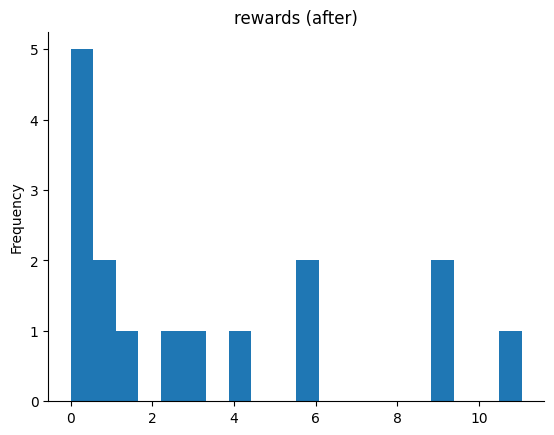

In [27]:
# @title rewards (after)

from matplotlib import pyplot as plt
df_results['rewards (after)'].plot(kind='hist', bins=20, title='rewards (after)')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Save Aligned Model Objects

In [24]:
ALIGNED_MODEL_NAME

'aligned-gpt2-movie_reviewer'

In [25]:
model.save_pretrained(ALIGNED_MODEL_NAME)
tokenizer.save_pretrained(ALIGNED_MODEL_NAME)

('aligned-gpt2-movie_reviewer/tokenizer_config.json',
 'aligned-gpt2-movie_reviewer/special_tokens_map.json',
 'aligned-gpt2-movie_reviewer/vocab.json',
 'aligned-gpt2-movie_reviewer/merges.txt',
 'aligned-gpt2-movie_reviewer/added_tokens.json',
 'aligned-gpt2-movie_reviewer/tokenizer.json')

In [26]:
if SAVE_TRAINED_OBJECTS and HF_NAMESPACE_TO_PUSH_TO is not "XXXXXX":
    hf_repo_id = f"{HF_NAMESPACE_TO_PUSH_TO}/{ALIGNED_MODEL_NAME}"
    model.push_to_hub(
        hf_repo_id,
        commit_message="Add model object, PPO alignment done")
    tokenizer.push_to_hub(
        hf_repo_id,
        commit_message="Add tokenizer object, PPO alignment done")
else:
    print("You have chosen not to push objects to any HF namespace/repo")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/raghavbali/aligned-gpt2-movie_reviewer/commit/2fcc93f09aad019ef27ccf064d447cbd50e6472b', commit_message='PPO alignment done', commit_description='', oid='2fcc93f09aad019ef27ccf064d447cbd50e6472b', pr_url=None, pr_revision=None, pr_num=None)

## Generate and Compare Aligned vs Non-Aligned Models

In [28]:
from IPython.display import display, Markdown

In [29]:
hub_model = AutoModelForCausalLMWithValueHead.from_pretrained(f'./{ALIGNED_MODEL_NAME}').to(device) #,cache_dir="/workspace/"
# create a reference model
hub_tokenizer = AutoTokenizer.from_pretrained(f'./{ALIGNED_MODEL_NAME}',) #cache_dir="/workspace/"

hub_tokenizer.pad_token = tokenizer.eos_token

Some weights of the model checkpoint at ./aligned-gpt2-movie_reviewer were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
reviews = [
    "No big names",
    "The director",
    "What",
    "Lame",
    "Space invaders",
    "Here are my 2 cents on the movie",

]

In [41]:
for review in reviews:
    inputs = hub_tokenizer(review, return_tensors="pt", return_token_type_ids=False).to(device)
    display(Markdown((f"### Prompt: {review}...")))
    display(Markdown(("#### ALIGNED-MODEL ")))
    outputs = hub_model.generate(**inputs,max_new_tokens=25,temperature=0.8,do_sample=True, pad_token_id=tokenizer.eos_token_id)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    display(Markdown(("#### NON- ALIGNED-MODEL ")))
    outputs = ref_model.generate(**inputs, max_new_tokens=25,temperature=0.8,do_sample=True, pad_token_id=tokenizer.eos_token_id)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    display(Markdown(("---")))

### Prompt: No big names...

#### ALIGNED-MODEL 

No big names in this movie, but I can't wait for it to come to see me again! There are plenty of things that are

#### NON- ALIGNED-MODEL 

No big names, but I really like the ending. I thought that was a bit too long and boring. This is a great story about

---

### Prompt: The director...

#### ALIGNED-MODEL 

The director, Martin Scorsese, plays the character of a man who goes missing from his home in Ireland. He is haunted by

#### NON- ALIGNED-MODEL 

The director of "Black Mirror" David Lynch knows what to do with his own dead brother. His film has become the subject of a

---

### Prompt: What...

#### ALIGNED-MODEL 

What I've seen on television is an absolutely stunning, moving, moving, and extremely entertaining story of the life of a beautiful young

#### NON- ALIGNED-MODEL 

What to do:

 of the new movies is really very good. I would recommend this film to anyone that likes the gritty

---

### Prompt: Lame...

#### ALIGNED-MODEL 

Lame with the money and the lack of a proper score. I liked the script and the characters, but I couldn't stomach the

#### NON- ALIGNED-MODEL 

Lame in the name of a good guy, but he's not a bad guy. He doesn't seem like a guy who has

---

### Prompt: Space invaders...

#### ALIGNED-MODEL 

Space invaders from the 20th Century, they were great films. I would recommend this to someone who is into horror and suspense. They

#### NON- ALIGNED-MODEL 

Space invaders, are a part of the film. The plot is based on a comic book which has been published as a comic book.

---

### Prompt: Here are my 2 cents on the movie...

#### ALIGNED-MODEL 

Here are my 2 cents on the movie. There are some great action and the characters are well crafted. Everything about this movie will be enjoyable and funny. The script

#### NON- ALIGNED-MODEL 

Here are my 2 cents on the movie. I was very disappointed in the performance of the story and the plot. The main character was really bad and I was impressed

---